In [1]:
import numpy as np
import pandas as pd
from radioReduction import *
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.optimize as op
import random
import emcee
import corner


In [2]:
'''
Importing the data and binning every 10 seconds
'''
dt = pd.read_table('1314/dataTables/2M1314e15-LLRR.dat')
binned = binning(dt,sec=10)

def binPlot(Type='sec'):
    if Type == 'minutes':
        plt.errorbar(binned['dtmin'],binned['re'],yerr=binned['ure'],linestyle='None',color='k',label='_nolegend_')
        plt.scatter(binned['dtmin'],binned['re'],color='black',label='Data')
    else:
        plt.errorbar(binned['secs'],binned['re'],yerr=binned['ure'],linestyle='None',color='k',label='_nolegend_')
        plt.scatter(binned['secs'],binned['re'],color='black',label='Data') 

/home/russell/projects/radio_project/radioReduction.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['secs'] = data['dtmin']*60


In [3]:
'''
Defining our model, likelihoood, and prior functions
'''
def linearModel(theta,x):
    '''
    Linear model fitting to the data
    '''
    m,b = theta
    y = m*x+b
    return y

def lnprior(theta):
    '''
    Uniform priors for m and b constrained by the data
    '''
    m,b = theta
    if 0 < m < 1 and .5 < b < 1.5:
        return 0.0
    return -np.inf

def lnlike(theta,x,y,yerr):
    '''
    Log of the likelihood function (chi^2)
    '''
    return -0.5*(np.sum((y-linearModel(theta,x))**2/yerr**2))

def lnprob(theta,x,y,err):
    '''
    Putting prior and likelihood together
    '''
    lnp = lnprior(theta)
    if not np.isfinite(lnp):
        return -np.inf
    return lnp + lnlike(theta,x,y,yerr)

In [4]:
# Putting data to variables
x = binned['dtmin']
y = binned['re']
yerr = binned['ure']

In [6]:
# Optimizing the lnlikelihood
# Minimize to -log of the likelihood to maximize the likelihood
nll = lambda *args: -lnlike(*args)
x0 = [5,3]
linearResult = op.minimize(nll,x0,args=(x,y,yerr))
m_ml,b_ml = linearResult.x
print(m_ml,b_ml)


0.03117856850882582 1.110286464374164


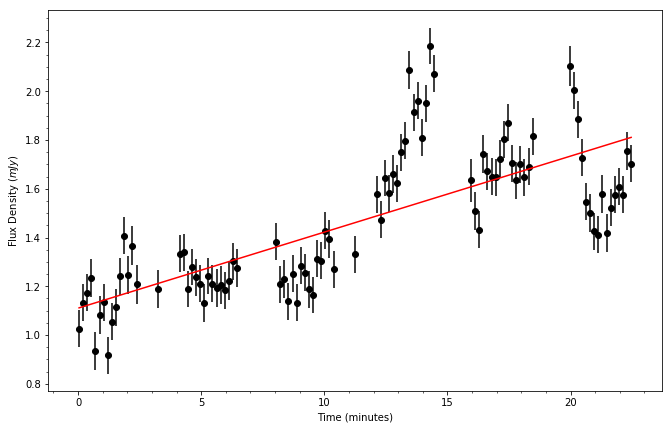

In [12]:
# Plotting results from maximized likelihood
plt.figure(figsize=(11,7))
binPlot(Type='minutes')
plt.plot(x,linearModel([m_ml,b_ml],x),color='red',label='Linear Model')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.minorticks_on()
plt.savefig('plots/1314e15_linearModel.png')
plt.show()

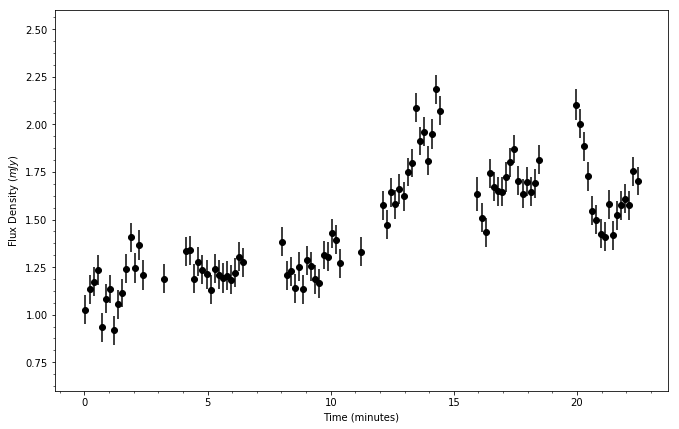

In [65]:
# Plotting results from maximized likelihood
plt.figure(figsize=(11,7))
binPlot(Type='minutes')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.ylim(0.6,2.6)
plt.minorticks_on()
#plt.savefig('plots/1314e15_stokesI.png')
plt.show()

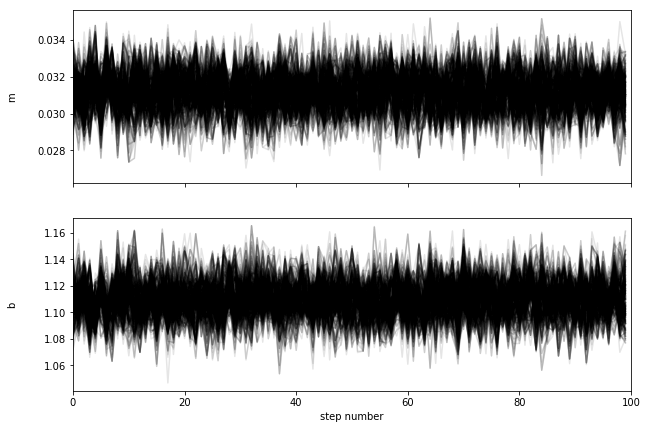

(array([[0.03060286, 1.12358973],
        [0.03283352, 1.07626738],
        [0.03162118, 1.1227934 ],
        [0.03026133, 1.11831778],
        [0.03347209, 1.08648262],
        [0.03200523, 1.10287884],
        [0.03229886, 1.08803063],
        [0.03085749, 1.11774043],
        [0.03150762, 1.11356015],
        [0.03071926, 1.1112688 ],
        [0.03000369, 1.13067317],
        [0.0301417 , 1.13015039],
        [0.0319129 , 1.10016282],
        [0.03117418, 1.10542862],
        [0.03033743, 1.13958579],
        [0.02992935, 1.12250615],
        [0.03173492, 1.11785157],
        [0.03075608, 1.12855083],
        [0.03161045, 1.09563486],
        [0.03098058, 1.11080932],
        [0.03024451, 1.1215069 ],
        [0.03127141, 1.11848326],
        [0.02917873, 1.14563931],
        [0.03334584, 1.08892043],
        [0.03114829, 1.09884523],
        [0.0314382 , 1.11377967],
        [0.03099552, 1.12435427],
        [0.03218354, 1.10449595],
        [0.03151483, 1.10159779],
        [0.031

In [14]:
'''
Running MCMC
'''
# 2 parameters, 100 walkers
ndim,nwalkers = 2,100

# Initial position somewhere close to the maximum likelihood result
p0 = [linearResult['x']+1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# Setting up the sampler
linearSampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(x,y,yerr))

# Running a burn in of 500 steps
pos, prob, state = linearSampler.run_mcmc(p0,500)

# Plotting the chains
fig, axes = plt.subplots(2,figsize=(10,7),sharex=True)
linearSamples = linearSampler.chain
labels = ['m','b']
for i in range(ndim):
    ax = axes[i]
    ax.plot(linearSamples[:,:,i],"k",alpha=0.1)
    ax.set_xlim(0,len(linearSamples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)
axes[-1].set_xlabel('step number')
plt.savefig('plots/1314e15_linearBurnTrace.png')
plt.show()

linearSampler.reset()

# Running MCMC
linearSampler.run_mcmc(pos,5000)

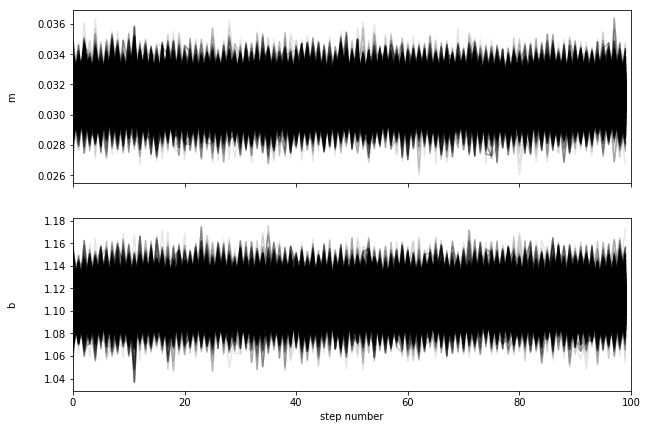

In [15]:
# Plotting the chains
fig, axes = plt.subplots(2,figsize=(10,7),sharex=True)
linearSamples = linearSampler.chain
labels = ['m','b']
for i in range(ndim):
    ax = axes[i]
    ax.plot(linearSamples[:,:,i],"k",alpha=0.1)
    ax.set_xlim(0,len(linearSamples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)
axes[-1].set_xlabel('step number')
plt.savefig('plots/1314e15_linearTrace.png')
plt.show()

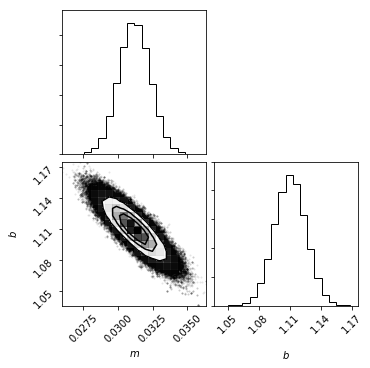

In [16]:
# Flattening the sampler
linearFlat = linearSampler.chain[:,:,:].reshape((-1,ndim))

fig = corner.corner(linearFlat,labels=['$m$','$b$'])
plt.savefig('plots/linearCorner.png')
plt.show()

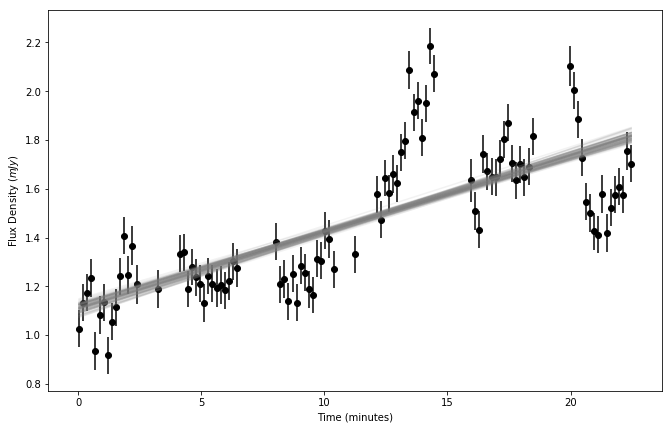

In [18]:
# Plotting first few MCMC steps on the data
plt.figure(figsize=(11,7))
binPlot(Type='minutes')
for m,b in linearFlat[np.random.randint(len(linearFlat),size=100)]:
    plt.plot(binned['dtmin'],m*binned['dtmin']+b,color='gray',alpha=0.1)
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.savefig('plots/1314e15_500mcmc_data.png')
plt.show()

In [19]:
# Calculating the uncertainties based off of 16th,50th, and 84th percentile
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(linearFlat[:,i],[16,50,84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [48]:
# Getting the 50th percentile of each parameter
linearParameters = []

for i in range(ndim):
    linearParameters.append(np.percentile(linearFlat[:,i],50))
linearParameters = np.array(linearParameters)

# Making model line
linear_model = linearModel(linearParameters,x)

# Residuals
linear_resid = y - linear_model

# Plotting the 50th percentile against the data along with residuals
plt.figure(figsize=(11,7))
plt.plot([], [], ' ', label="Reduced $\chi^2 = 6.54$")
plt.errorbar(x,y,yerr=yerr,color='black',linestyle='None',label='Data',fmt='o')
plt.plot(x,linear_model,color='red',label='Linear Model')
plt.errorbar(x,linear_resid,yerr=yerr,color='gray',linestyle='None',label='Residuals',fmt='v')
plt.axhline(y=0,color='black')
plt.legend(loc='best')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.minorticks_on()
plt.savefig('plots/1314e15_linearModel_fit.png')
plt.show()

IndexError: index 2 is out of bounds for axis 1 with size 2

In [30]:
# calculating chi_square
def chiSquare(theta,y,yerr):
    return np.sum(np.square((y-linearModel(theta,x))/yerr))
chiSquare(linearParameters,y,yerr)/(len(y)-1)

6.547435747804102

## Fitting an logistic function


In [11]:
def logModel(theta,x):
    '''
    Logistic model w/ added term y0 to translate it up
    '''
    l,k,x0,y0 = theta
    denom = 1+np.exp(-k*(x-x0))
    return y0+l/denom

def lnlike(theta,x,y,yerr):
    '''
    Log of the likelihood function (chi^2)
    '''
    return -0.5*(np.sum((y-logModel(theta,x))**2/yerr**2))

def lnprior(theta):
    '''
    Uniform priors for a and b constrained by the data
    '''
    l,k,x0,y0 = theta
    if 0 < l < 2.5 and -5 < k < 10 and 9 < x0 < 15 and 1.0 < y0 < 1.4:
        return 0.0
    return -np.inf

def lnprob(theta,x,y,err):
    '''
    Putting prior and likelihood together
    '''
    lnp = lnprior(theta)
    if not np.isfinite(lnp):
        return -np.inf
    return lnp + lnlike(theta,x,y,yerr)

In [6]:
# Optimizing the lnlikelihood
# Minimize to -log of the likelihood to maximize the likelihood
x = binned['dtmin']
nll = lambda *args: -lnlike(*args)
p0 = [2,6,10,1]
logResult = op.minimize(nll,p0,args=(x,y,yerr))
l_ml,k_ml,x0_ml,y0_ml = logResult.x

print(l_ml,k_ml,x0_ml,y0_ml)

0.5141892557057575 1.632067234100602 11.340545971673912 1.2052192399279913


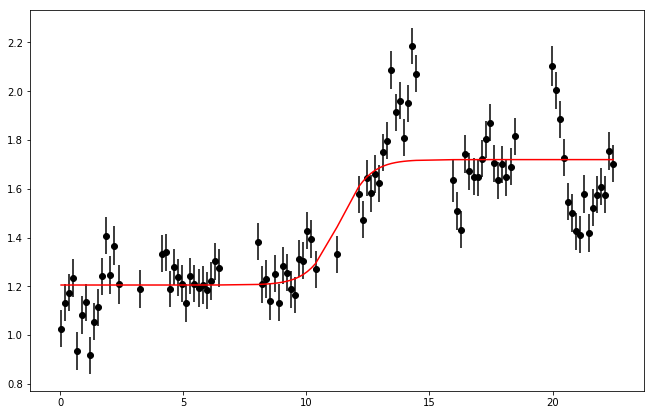

In [34]:
plt.figure(figsize=(11,7))
binPlot(Type='minutes')
plt.plot(x,logModel([l_ml,k_ml,x0_ml,y0_ml],x),color='red')
plt.show()

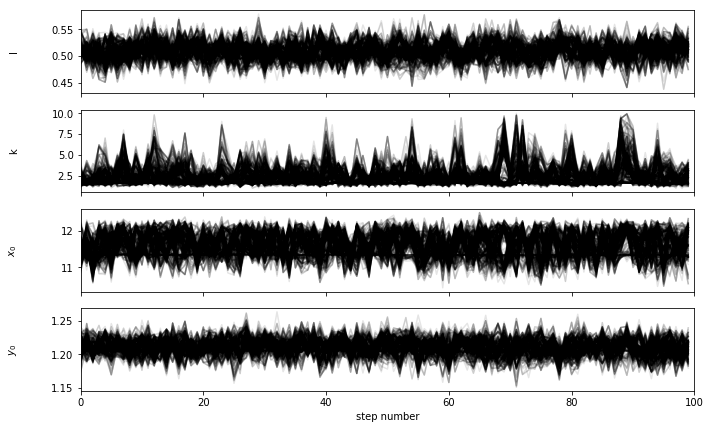

(array([[ 0.49852761,  6.13069538, 11.81989595,  1.22453382],
        [ 0.53050816,  2.2665488 , 11.66396451,  1.20378701],
        [ 0.48698885,  2.99782431, 11.49240126,  1.22532192],
        [ 0.50533481,  1.89796637, 11.47648191,  1.20992886],
        [ 0.49041166,  3.63925463, 12.01272859,  1.22394381],
        [ 0.53426967,  1.72644158, 11.41686956,  1.18985647],
        [ 0.50504579,  2.4596939 , 11.98924179,  1.24155574],
        [ 0.48676262,  1.92860421, 11.75873961,  1.22027688],
        [ 0.51407818,  1.65144717, 11.21375279,  1.21330027],
        [ 0.50004143,  3.22903407, 12.12889414,  1.20226763],
        [ 0.5095511 ,  1.37418453, 11.25302213,  1.20046011],
        [ 0.50103938,  2.05497286, 11.45705184,  1.21369478],
        [ 0.50437556,  1.54308508, 10.52708557,  1.19893365],
        [ 0.49887849,  1.72032093, 11.20172792,  1.2072916 ],
        [ 0.5304424 ,  4.37669436, 11.72527489,  1.1984033 ],
        [ 0.53243217,  1.74815346, 11.4111411 ,  1.19414163],
        

In [35]:
'''
Running MCMC
'''
# 2 parameters, 100 walkers
ndim,nwalkers = 4,100

# Initial position somewhere close to the maximum likelihood result
p0 = [logResult['x']+1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# Setting up the sampler
logSampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(x,y,yerr))

# Running a burn in of 100 steps
pos, prob, state = logSampler.run_mcmc(p0,500)
# Plotting the chains
fig, axes = plt.subplots(4,figsize=(11,7),sharex=True)
logSamples = logSampler.chain
labels = ['l','k','$x_0$','$y_0$']
for i in range(4):
    ax = axes[i]
    ax.plot(logSamples[:,:,i],"k",alpha=0.1)
    ax.set_xlim(0,len(logSamples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)
axes[-1].set_xlabel('step number')
plt.savefig('1314e15_LogBurnTrace.png')
plt.show()
logSampler.reset()

# Running MCMC
logSampler.run_mcmc(pos,5000)

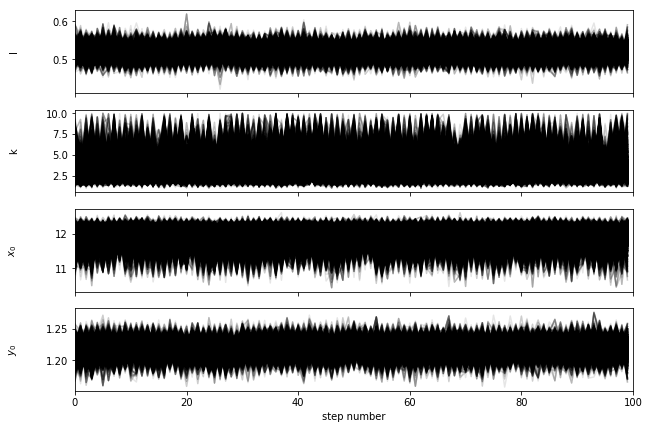

In [192]:
# Plotting the chains
fig, axes = plt.subplots(4,figsize=(10,7),sharex=True)
logSamples = logSampler.chain
labels = ['l','k','$x_0$','$y_0$']
for i in range(4):
    ax = axes[i]
    ax.plot(logSamples[:,:,i],"k",alpha=0.1)
    ax.set_xlim(0,len(logSamples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)
axes[-1].set_xlabel('step number')
plt.savefig('1314e15_Trace.png')
plt.show()

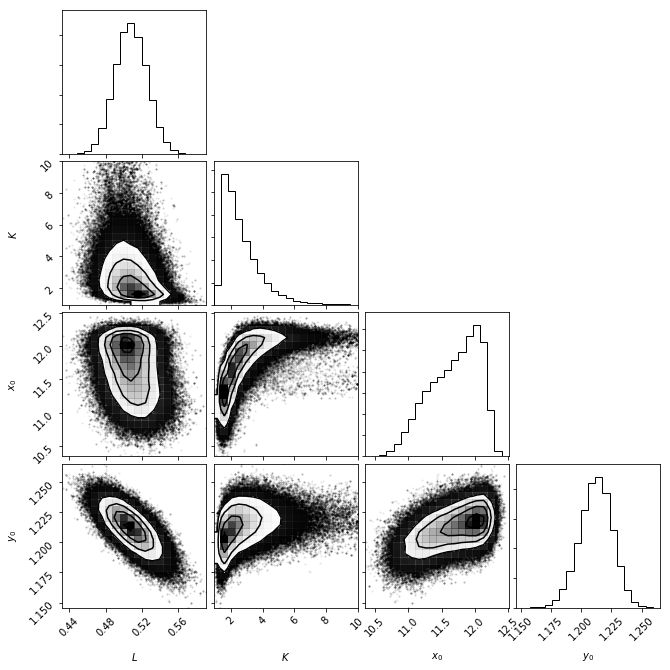

In [36]:
# Flattening the sampler
logFlat = logSampler.chain[:,:,:].reshape((-1,4))
fig = corner.corner(logFlat,labels=['$L$','$K$','$x_0$','$y_0$'])
plt.savefig('plots/e15_logCorner.png')
plt.show()

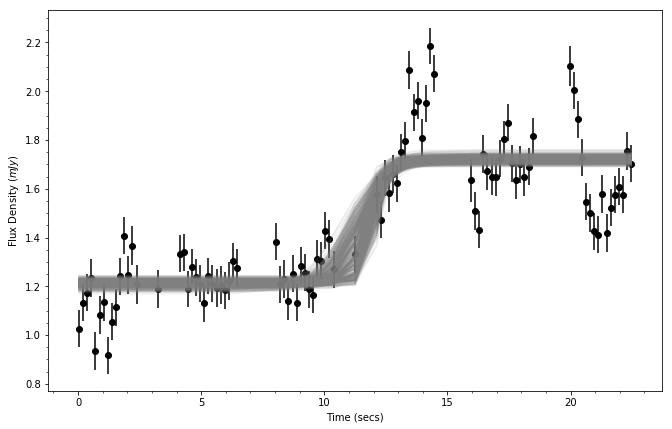

In [38]:
# Plotting first few MCMC steps on the data
plt.figure(figsize=(11,7))
binPlot(Type='minutes')
for l,k,x0,y0 in logFlat[np.random.randint(len(logFlat),size=500)]:
    plt.plot(x,logModel([l,k,x0,y0],x),color='gray',alpha=0.1)
plt.xlabel('Time (secs)')
plt.ylabel('Flux Density ($mJy$)')
plt.minorticks_on()
plt.savefig('plots/500mcmc_log.png')
plt.show()

In [39]:
# Calculating the uncertainties based off of 16th,50th, and 84th percentile
from IPython.display import display, Math

for i in range(4):
    mcmc = np.percentile(logFlat[:,i],[16,50,84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

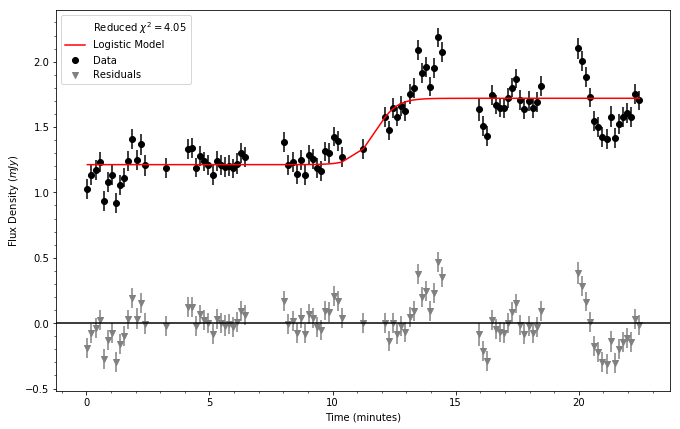

In [49]:
# Getting the 50th percentile of each parameter
logParameters = []

for i in range(4):
    logParameters.append(np.percentile(logFlat[:,i],50))
logParameters = np.array(logParameters)

# Making logistic model
log_model = logModel(logParameters,x)

# Calculating residuals
logResid = y - log_model

# Plotting against the data
plt.figure(figsize=(11,7))
binPlot(Type='minutes')
plt.plot([], [], ' ', label="Reduced $\chi^2 = 4.05$")
plt.plot(x,log_model,color='red',label='Logistic Model')
plt.scatter(x,logResid,color='gray',marker='v',label='Residuals')
plt.errorbar(x,logResid,yerr=yerr,color='gray',label='_nolegend_',linestyle='None')
plt.axhline(y=0,color='black')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.legend(loc='best')
plt.minorticks_on()
plt.savefig('plots/e15_logModel.png')
plt.show()

In [60]:
# calculating chi_square
def chiSquare(theta,y,yerr):
    return np.sum(np.square((y-logModel(theta,x))/yerr))
chiSquare(logParameters,y,yerr)/90

NameError: name 'logParameters' is not defined

## e15 Looking at Stokes I, V and circular polarization

In [3]:
rr = pd.read_table('1314/dataTables/2M1314e15-RR.dat')
ll = pd.read_table('1314/dataTables/2M1314e15-LL.dat')

rr = binning(rr,10)
ll = binning(ll,10)

/home/russell/projects/radio_project/radioReduction.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['secs'] = data['dtmin']*60


In [4]:
stI = (rr['re']+ll['re'])*.5
stV = (rr['re']-ll['re'])*.5
frac = stV/stI
stErr = np.sqrt(rr['ure']**2+ll['ure']**2)*.5
time = rr['dtmin']

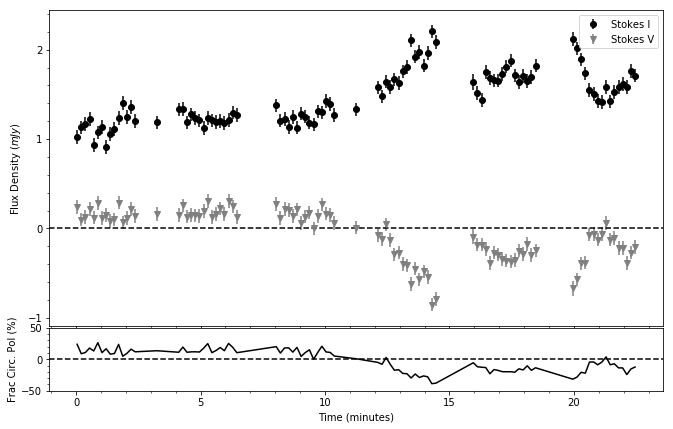

In [5]:
fig,ax = plt.subplots(figsize=(11,7),nrows=2,ncols=1,sharex=True,gridspec_kw = {'hspace':.01,'height_ratios':[5,1]})
ax[0].errorbar(time,stI,yerr=stErr,color='k',linestyle='None',label='Stokes I',fmt='o')
ax[0].errorbar(time,stV,yerr=stErr,color='gray',linestyle='None',label='Stokes V',fmt='v')
ax[0].axhline(y=0,color='k',linestyle='dashed')
ax[0].legend(loc='best')
ax[0].set_ylabel('Flux Density ($mJy$)')
ax[0].locator_params(axis='y',nbins=4)
ax[0].minorticks_on()

ax[1].plot(time,100*frac,color='k')
ax[1].axhline(y=0,color='k',linestyle='dashed')
ax[1].set_ylim(-50,50)
ax[1].set_ylabel('Frac Circ. Pol (%)')
ax[1].minorticks_on()

plt.xlabel('Time (minutes)')
plt.savefig('plots/e15_stokes.png')
plt.show()

In [59]:
modelSub = stI - log_model

plt.figure(figsize=(10,7))
plt.scatter(time,modelSub,color='k',marker='o',label='Model Subtracted')
plt.errorbar(time,modelSub,yerr=stErr,color='k',linestyle='None',label='_nolegend_')
plt.axhline(y=0,color='k',linestyle='dashed')
plt.ylim(-0.5,0.8)
plt.legend(loc='best')
plt.show()

NameError: name 'log_model' is not defined

In [13]:
'''
Calculating the average Stokes V value in quiescent and active emission states
'''

stokes = (stI,stV,time,stErr)
activeV = stokes[1][stokes[2]>11.5]
activeErr = stokes[3][stokes[2]>11.5]
activeErr = 1/np.sqrt(np.sum(1/np.square(activeErr)))

quieV = stokes[1][stokes[2]<11.5]
quieErr = stokes[3][stokes[2]<11.5]
quieErr = 1/np.sqrt(np.sum(1/np.square(quieErr)))



print(np.average(activeV),activeErr,np.average(quieV),quieErr)

-0.2997469480832356 0.01115419218782513 0.16379816102718536 0.011136365818992366


In [16]:
high = pd.read_table('1314/dataTables/2M1314e15-7GHz.dat')
low = pd.read_table('1314/dataTables/2M1314e15-5GHz.dat')

high = high[high['nsamp']>3000]
low = low[low['nsamp']>3000]

high = binning(high,10)
low = binning(low,10)


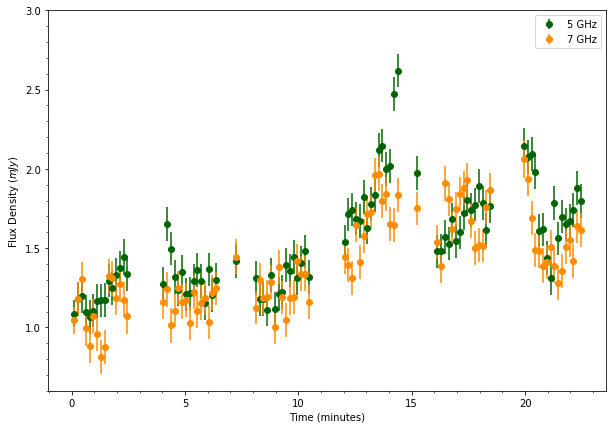

In [17]:
plt.figure(figsize=(10,7))
plt.errorbar(low['dtmin'],low['re'],yerr=low['ure'],marker='o',linestyle='None',color='darkgreen',label='5 GHz')
plt.errorbar(high['dtmin'],high['re'],yerr=high['ure'],marker='o',linestyle='None',color='darkorange',label='7 GHz')
plt.legend(loc='best')
plt.ylim(0.6,3)
plt.minorticks_on()
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.savefig('plots/1314_e15_SED.png')
plt.show()

In [18]:
from pwkit.environments.casa import dftdynspec as ds

In [19]:
from pwkit.environments.casa.dftdynspec import Loader

In [20]:
path = '1314/dataTables/2M1314e15_dynspec.dat'
ds = Loader(path)

In [21]:
ds.reals.max()

0.009821442029669392

In [22]:
ds

In [23]:
ds.reals.shape

(190, 16)

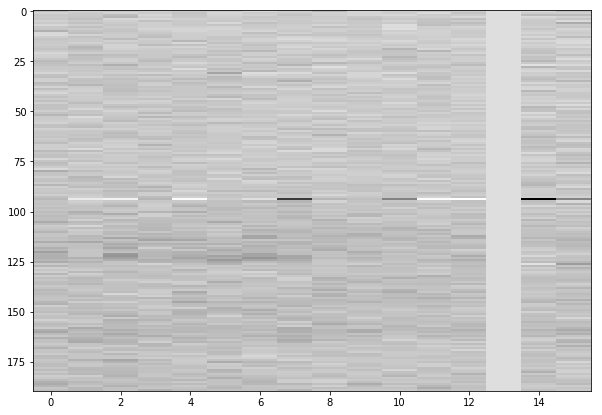

In [24]:
plt.figure(figsize=(10,7))
plt.imshow(ds.reals,aspect='auto',cmap='Greys')


In [25]:
re = ds.reals
ure = ds.u_reals
freq = ds.freqs

In [26]:
re.shape

(190, 16)

In [27]:
ds.mjds

array([57634.98826023, 57634.9883181 , 57634.98837597, 57634.98843384,
       57634.98849171, 57634.98854958, 57634.98860745, 57634.98866532,
       57634.98872319, 57634.98878106, 57634.98883894, 57634.98889681,
       57634.98895468, 57634.98901255, 57634.98907042, 57634.98912829,
       57634.98918616, 57634.98924403, 57634.9893019 , 57634.98935977,
       57634.98941764, 57634.98947551, 57634.98953338, 57634.98959125,
       57634.98964912, 57634.98970699, 57634.98976486, 57634.98982273,
       57634.9898806 , 57634.98993847, 57634.98999634, 57634.99005421,
       57634.99103801, 57634.99109588, 57634.99115375, 57634.99121162,
       57634.99126949, 57634.99132736, 57634.99138523, 57634.9914431 ,
       57634.99150097, 57634.99155884, 57634.99161671, 57634.99167458,
       57634.99173245, 57634.99179032, 57634.99184819, 57634.99190606,
       57634.99196394, 57634.99202181, 57634.99207968, 57634.99213755,
       57634.99219542, 57634.99225329, 57634.99231116, 57634.99236903,
      

190


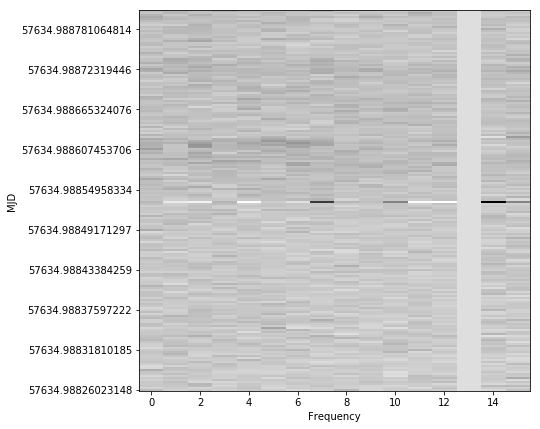

In [28]:
ticks = np.arange(0,ds.mjds.shape[0],20) # makes ticks

plt.figure(figsize=(7,7))
plt.yticks(ticks,labels=ds.mjds)
plt.imshow(ds.reals,aspect='auto',origin='lower',cmap='Greys')
plt.ylabel('MJD')
plt.xlabel('Frequency')

print(ds.mjds.shape[0])

#plt.savefig('plots/2M1314e15-dynspec.png')




In [53]:
print(wt_avg.shape)
print(time_avg.shape)
print(ds.reals.shape)

(48, 16)
(48,)
(190, 16)


/home/russell/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in power
  # Remove the CWD from sys.path while we load stuff.
/home/russell/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':


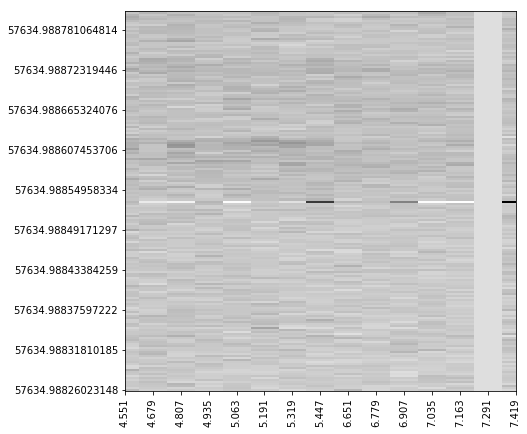

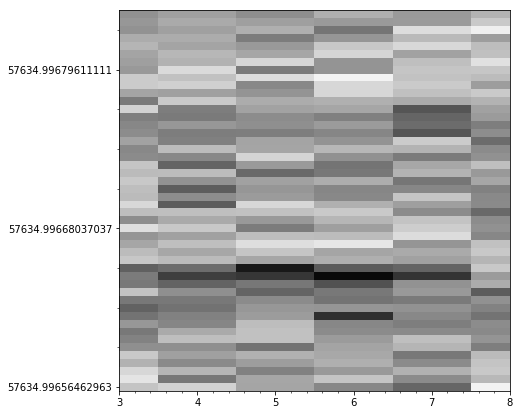

In [52]:
# Re-interpret as 4D
reals = ds.reals[94:]
uncert = ds.u_reals[94:]
time = ds.mjds[94:]
r_data = reals.reshape((48,2,16,1))
r_uncerts = uncert.reshape((48,2, 16,1))
r_time  = time.reshape((48,2))

# Proceed as before, but now sum along two axes.
r_weights = r_uncerts ** -2
wt_avg = (r_data * r_weights).sum(axis=(1,3)) / r_weights.sum(axis=(1,3))
uncert_wt_avg = 1 / np.sqrt(r_weights.sum(axis=(1,3)))
time_avg = r_time.mean(axis=1)


# Creating Tics
ticks_1 = np.arange(0,ds.mjds.shape[0],20) # makes ticks
ticks_2 = np.arange(0,time_avg.shape[0],20) # makes ticks


plt.figure(figsize=(7,7))
plt.xlim(3,8)
plt.xticks(np.arange(15),labels=np.round(ds.freqs,3),rotation=90)
plt.yticks(ticks_1,labels=ds.mjds)
plt.imshow(ds.reals,aspect='auto',origin='lower',cmap='Greys')


plt.figure(figsize=(7,7))
plt.yticks(ticks_2,labels=time_avg)
plt.imshow(wt_avg,aspect='auto',origin='lower',cmap='Greys')
#plt.xticks(np.round(ds.freqs,3),labels=np.round(ds.freqs,3),rotation=90)
plt.xlim(3,8)
plt.minorticks_on()


In [290]:
wt

array([0.00155003, 0.00154491, 0.00166334, 0.00179036, 0.00191677,
       0.00223961, 0.00149109, 0.00154102, 0.00181593, 0.00163866,
       0.0020801 , 0.00165707, 0.00226949, 0.0027039 , 0.00246044,
       0.00240726, 0.00189267, 0.00111135, 0.00151206, 0.00140181,
       0.00162591, 0.00159674, 0.00183149, 0.00192313, 0.00156563,
       0.00182677, 0.00165379, 0.00163482, 0.00151999, 0.00170876,
       0.00113888, 0.00190462, 0.00189662, 0.0023992 , 0.00191013,
       0.00167721, 0.00146207, 0.00190595, 0.001313  , 0.0019552 ,
       0.00149973, 0.00189211, 0.00164908, 0.00155156, 0.00113041,
       0.00216634, 0.00244582, 0.00164253])

In [31]:

print(ds.reals.shape)
print(r_data.shape)
print(wt_avg[1])

'''
plt.figure(figsize=(11,7))
plt.errorbar(wt_avg[0],wt_avg[1],yerr=uncert_wt_avg)
plt.show()
'''

(190, 16)
(48, 2, 16, 1)
[0.00154491 0.0014338  0.00202536 0.00092732 0.00215152 0.00168166
 0.00137597 0.00194448 0.00150999 0.00133345 0.00177165 0.00161468
 0.00159942        nan 0.00100039 0.00158773]


'\nplt.figure(figsize=(11,7))\nplt.errorbar(wt_avg[0],wt_avg[1],yerr=uncert_wt_avg)\nplt.show()\n'

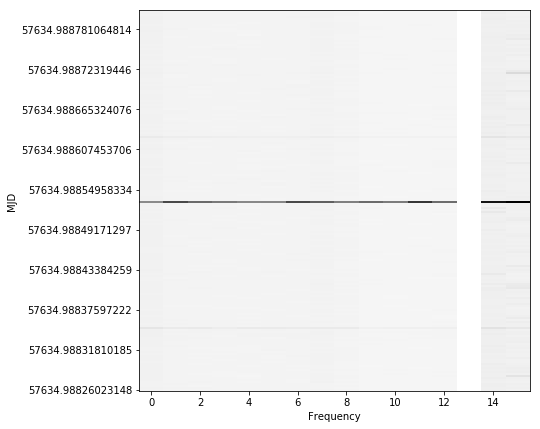

In [32]:
ticks = np.arange(0,ds.mjds.shape[0],20) # makes ticks

plt.figure(figsize=(7,7))
plt.yticks(ticks,labels=ds.mjds)
plt.imshow(ds.u_reals,aspect='auto',origin='lower',cmap='Greys')
plt.ylabel('MJD')
plt.xlabel('Frequency')

plt.savefig('plots/2M1314e15-dynspecNoise.png')

In [33]:
results = np.where(ds.u_reals > 0.0008)

In [34]:
np.asarray(results).T

array([[  7,  15],
       [ 31,  14],
       [ 94,   0],
       [ 94,   1],
       [ 94,   2],
       [ 94,   3],
       [ 94,   4],
       [ 94,   5],
       [ 94,   6],
       [ 94,   7],
       [ 94,   8],
       [ 94,   9],
       [ 94,  10],
       [ 94,  11],
       [ 94,  12],
       [ 94,  14],
       [ 94,  15],
       [126,  14],
       [158,  15]])

In [35]:
ds.mjds[94]

57634.996535694445

In [278]:
ds.reals[94:].shape

(96, 16)

In [36]:
xx = binned[binned['mjd'] < 57634.996535694445]
yy = binned[binned['mjd'] > 57634.996535694445]

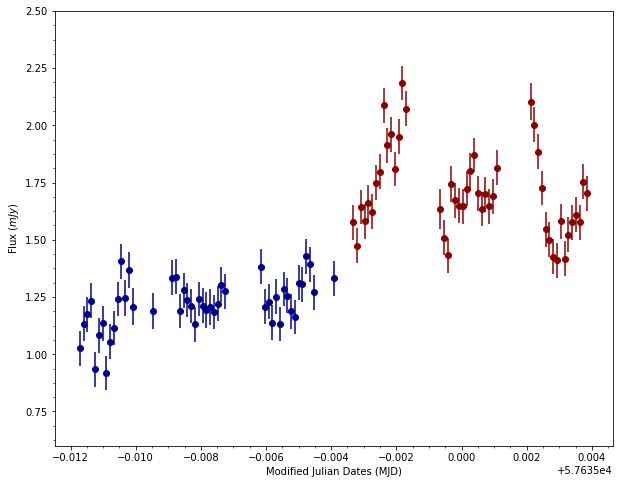

In [37]:
plt.figure(figsize=(10,8))
plt.errorbar(xx['mjd'],xx['re'],yerr=xx['ure'],fmt='o',linestyle='none',color='darkblue')
plt.errorbar(yy['mjd'],yy['re'],yerr=yy['ure'],fmt='o',linestyle='none',color='darkred')
plt.ylim(0.6,2.5)
plt.xlabel('Modified Julian Dates (MJD)')
plt.ylabel('Flux ($mJy$)')
plt.minorticks_on()
plt.savefig('plots/1314e14_glitch.png')
plt.show()


In [38]:
weights = (ds.u_reals)**-2
weights

/home/russell/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in power
  """Entry point for launching an IPython kernel.


array([[4707334.06915801, 5684744.94886391, 6155356.39873075, ...,
                     inf, 3151439.58185913, 4363924.57052366],
       [4480151.75214983, 5265574.13433169, 5146112.52108228, ...,
                     inf, 3308695.8957897 , 3416467.22339759],
       [4798698.4806896 , 5796174.13628429, 6437261.67689427, ...,
                     inf, 3098652.43848806, 3665214.17340519],
       ...,
       [4787195.75371369, 5726106.17609813, 5892700.92028801, ...,
                     inf, 3776491.051685  , 4176559.71867492],
       [4084488.79412177, 5836411.01804944, 5775348.89209824, ...,
                     inf, 3038366.14394702, 4263229.13292077],
       [4622417.76944724, 5998746.54637054, 6117467.54529465, ...,
                     inf, 3647273.30641368, 4273330.38707173]])

Text(0.5, 0, 'Frequency')

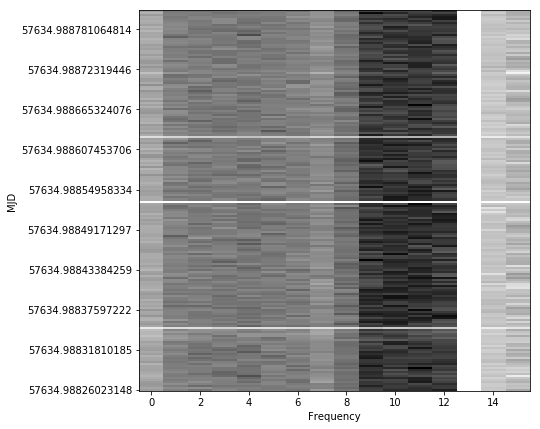

In [39]:
ticks = np.arange(0,ds.mjds.shape[0],20) # makes ticks

plt.figure(figsize=(7,7))
plt.yticks(ticks,labels=ds.mjds)
plt.imshow(weights,aspect='auto',origin='lower',cmap='Greys')
plt.ylabel('MJD')
plt.xlabel('Frequency')


In [40]:
# We have 80 measurements and 80 uncerts; nonsense values
# used here
data = np.random.normal(size=80)
uncerts = np.ones(80)

# Re-interpret the arrays as 8-by-10 2D arrays
r_data = data.reshape((8, 10))
r_uncerts = uncerts.reshape((8, 10))

# Proceed as before, but only sum along one axis each time. We sum
# along the 1-th axis, which is counted starting from zero -- so
# we're summing along the rightmost axis, the one of size 10.
r_weights = r_uncerts ** -2
wt_avg = (r_data * r_weights).sum(axis=1) / r_weights.sum(axis=1)
uncert_wt_avg = 1 / np.sqrt(r_weights.sum(axis=1))

In [41]:
print(wt_avg,uncert_wt_avg)

[-0.26055112 -0.22642046 -0.24502273  0.0629926   0.02368309  0.76631633
  0.94404898  0.10257467] [0.31622777 0.31622777 0.31622777 0.31622777 0.31622777 0.31622777
 0.31622777 0.31622777]


In [42]:
data

array([ 0.99852798, -0.6532198 ,  0.08573557, -0.76496509, -0.19841949,
       -0.89179138, -2.26833386,  0.33189129,  0.66574682,  0.08931676,
       -0.20196549,  0.24506305, -1.71165354,  0.25630002, -1.48248428,
        1.40237973,  0.77627958, -1.13828519,  0.23067204, -0.64051053,
        0.24785614,  2.18826644, -1.08431415, -0.28024661, -1.30089935,
       -0.94146963,  1.67899776, -1.76940787, -1.51462464,  0.32561457,
        2.08001817, -0.37857526,  0.06345691,  1.43823834, -1.98989492,
        0.4730137 , -1.12329635, -2.18735897,  1.11248217,  1.14184225,
        1.33098692, -0.08818897,  0.51010425, -1.15005853,  0.97499547,
       -0.06589791, -0.67773589, -0.9379191 ,  0.96015169, -0.61960703,
        0.15432593,  0.69508463,  1.06526423, -0.09361282, -0.77901172,
        1.16284635,  1.63861642,  2.84629456,  0.19782727,  0.77552849,
       -0.30558756, -0.08579158,  1.96031502,  0.90055938,  1.93085023,
        2.58596036,  1.5522855 ,  0.27205805,  0.68609421, -0.05

In [43]:
# Data and uncertainty images
data = np.random.normal(size=(80, 120))
uncerts = np.ones((80, 120))

# Re-interpret as 4D
r_data = data.reshape((4, 20, 6, 20))
r_uncerts = uncerts.reshape((4, 20, 6, 20))

# Proceed as before, but now sum along two axes.
r_weights = r_uncerts ** -2
wt_avg = (r_data *
          r_weights).sum(axis=(1,3)) / r_weights.sum(axis=(1,3))
uncert_wt_avg = 1 / np.sqrt(r_weights.sum(axis=(1, 3)))

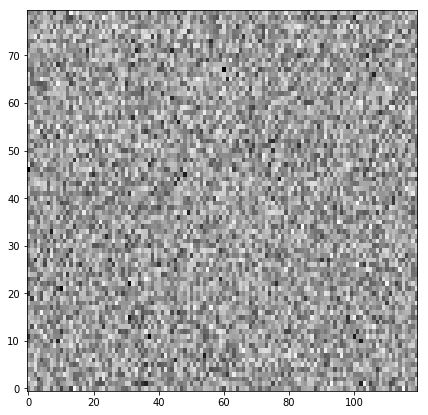

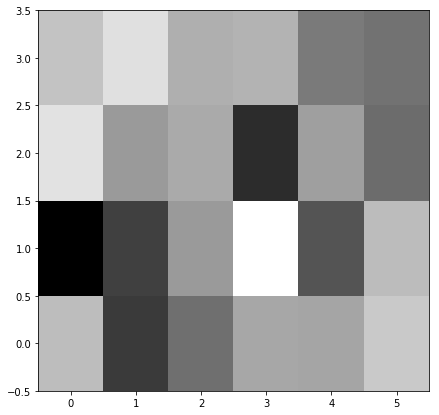

In [44]:
# Data and uncertainty images
data = np.random.normal(size=(80, 120))
uncerts = np.ones((80, 120))

# Re-interpret as 4D
r_data = data.reshape((4, 20, 6, 20))
r_uncerts = uncerts.reshape((4, 20, 6, 20))

# Proceed as before, but now sum along two axes.
r_weights = r_uncerts ** -2
wt_avg = (r_data *
          r_weights).sum(axis=(1,3)) / r_weights.sum(axis=(1,3))
uncert_wt_avg = 1 / np.sqrt(r_weights.sum(axis=(1, 3)))


plt.figure(figsize=(7,7))
plt.imshow(data,aspect='auto',origin='lower',cmap='Greys')



plt.figure(figsize=(7,7))
plt.imshow(wt_avg,aspect='auto',origin='lower',cmap='Greys')

